📘 Assignment 2 — Model D: Threshold & Cost/Fairness Policy

Project: original-wonder-471819-n2
Dataset: titanic_dataset
EVAL table: titanic_dataset.titanic_c (has split column)
Model used: titanic_dataset.engineered (from Model B)
Cost policy: C_FP = 1, C_FN = 4 (missed survivor is 4× cost of a false alert)

Goal: choose an operating threshold τ* that minimizes expected cost, compare vs default 0.50, and assess fairness by subgroup (sex and pclass). Save plots and provide a short, ops-ready policy + monitoring note.

In [8]:
from google.colab import auth
auth.authenticate_user()

import io, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from google.cloud import bigquery as bq
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# === Environment (standalone) ===
PROJECT_ID  = "original-wonder-471819-n2"
DATASET_ID  = "titanic_dataset"           # separate model name keeps you isolated
RAW_TABLE   = f"{DATASET_ID}.titanic"
EVAL_TABLE  = f"{DATASET_ID}.titanic_c"
MODEL_ID    = f"{DATASET_ID}.engineered_d"  # <-- your own engineered model
REGION      = "US"

# === Cost policy for Model D ===
C_FP = 1.0
C_FN = 4.0

client = bq.Client(project=PROJECT_ID)
print("Using:", PROJECT_ID, "| Dataset:", DATASET_ID, "| Tables:", RAW_TABLE, " / ", EVAL_TABLE, "| Model:", MODEL_ID)


Using: original-wonder-471819-n2 | Dataset: titanic_dataset | Tables: titanic_dataset.titanic  /  titanic_dataset.titanic_c | Model: titanic_dataset.engineered_d


In [9]:
# Upload train.csv from your computer
print("Upload train.csv from your computer…")
uploaded = files.upload()   # pick train.csv

name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[name]))
print("CSV loaded:", df.shape)
df.head()


Upload train.csv from your computer…


Saving train.csv to train (1).csv
CSV loaded: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# Ensure dataset exists and load/overwrite raw table
client.create_dataset(DATASET_ID, exists_ok=True)

raw_ref = f"{PROJECT_ID}.{RAW_TABLE}"
job = client.load_table_from_dataframe(df, raw_ref)
job.result()
print(f"✅ Raw titanic uploaded to {raw_ref}")


✅ Raw titanic uploaded to original-wonder-471819-n2.titanic_dataset.titanic


In [11]:
CANON_SQL = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{EVAL_TABLE}` AS
SELECT
  CAST(Survived AS INT64)  AS survived,
  CAST(Pclass   AS INT64)  AS pclass,
  CAST(Sex      AS STRING) AS sex,
  CAST(Age      AS FLOAT64) AS age,
  CAST(SibSp    AS INT64)  AS sibsp,
  CAST(Parch    AS INT64)  AS parch,
  CAST(Fare     AS FLOAT64) AS fare,
  CAST(Embarked AS STRING) AS embarked,
  CASE WHEN RAND() < 0.8 THEN 'TRAIN' ELSE 'EVAL' END AS split
FROM `{PROJECT_ID}.{RAW_TABLE}`
WHERE Age IS NOT NULL AND Fare IS NOT NULL AND Survived IS NOT NULL
"""
client.query(CANON_SQL, location=REGION).result()
print("✅ Canonical table ready:", f"{PROJECT_ID}.{EVAL_TABLE}")
client.query(f"SELECT split, COUNT(*) n FROM `{PROJECT_ID}.{EVAL_TABLE}` GROUP BY split", location=REGION).result().to_dataframe()


✅ Canonical table ready: original-wonder-471819-n2.titanic_dataset.titanic_c


,split,n
0,TRAIN,2849
1,EVAL,721


In [12]:
TRAIN_SQL = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{MODEL_ID}`
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['survived']
) AS
SELECT
  -- manifest
  pclass, sex, age, sibsp, parch, fare, embarked,
  survived,
  -- engineered features (same as Model B)
  (sibsp + parch + 1) AS family_size,
  CASE
    WHEN fare < 10 THEN 'low'
    WHEN fare < 50 THEN 'mid'
    ELSE 'high'
  END AS fare_bucket,
  CONCAT(LOWER(sex), '_', CAST(pclass AS STRING)) AS sex_pclass
FROM `{PROJECT_ID}.{EVAL_TABLE}`
WHERE split = 'TRAIN'
"""
job = client.query(TRAIN_SQL, location=REGION)
job.result()
print("✅ Engineered Model D trained:", f"{PROJECT_ID}.{MODEL_ID}")


✅ Engineered Model D trained: original-wonder-471819-n2.titanic_dataset.engineered_d


In [13]:
EVAL_SQL = f"""
SELECT * FROM ML.EVALUATE(
  MODEL `{PROJECT_ID}.{MODEL_ID}`,
  (SELECT survived, pclass, sex, age, sibsp, parch, fare, embarked,
          (sibsp + parch + 1) AS family_size,
          CASE WHEN fare < 10 THEN 'low' WHEN fare < 50 THEN 'mid' ELSE 'high' END AS fare_bucket,
          CONCAT(LOWER(sex), '_', CAST(pclass AS STRING)) AS sex_pclass
   FROM `{PROJECT_ID}.{EVAL_TABLE}`
   WHERE split='EVAL')
)
"""
eval_df = client.query(EVAL_SQL, location=REGION).result().to_dataframe()
print("Evaluation (Model D):"); eval_df


Evaluation (Model D):


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.864253,0.672535,0.829404,0.756436,0.403798,0.885183


In [14]:
PRED_SQL = f"""
WITH src AS (
  SELECT
    CAST(survived AS INT64) AS label,
    LOWER(CAST(sex AS STRING)) AS sex,
    CAST(pclass AS INT64) AS pclass,
    age, sibsp, parch, fare, embarked,
    (sibsp + parch + 1) AS family_size,
    CASE WHEN fare < 10 THEN 'low' WHEN fare < 50 THEN 'mid' ELSE 'high' END AS fare_bucket,
    CONCAT(LOWER(sex), '_', CAST(pclass AS STRING)) AS sex_pclass
  FROM `{PROJECT_ID}.{EVAL_TABLE}`
  WHERE split='EVAL' AND survived IS NOT NULL
),
pred AS (
  SELECT
    s.*,
    p.predicted_survived_probs[OFFSET(0)].prob AS score
  FROM ML.PREDICT(
    MODEL `{PROJECT_ID}.{MODEL_ID}`,
    (SELECT * FROM src)
  ) AS p
  JOIN src s ON TRUE
)
SELECT * FROM pred
"""
pred = client.query(PRED_SQL, location=REGION).result().to_dataframe()
assert len(pred)>0, "No EVAL predictions returned."
pred.head()


,label,sex,pclass,age,sibsp,parch,fare,embarked,family_size,fare_bucket,sex_pclass,score
0,0,male,3,19.0,0,0,8.1583,S,1,low,male_3,0.27947
1,0,male,3,61.0,0,0,6.2375,S,1,low,male_3,0.27947
2,0,female,3,2.0,0,1,10.4625,S,2,mid,female_3,0.27947
3,0,male,3,2.0,4,1,29.1250,Q,6,mid,male_3,0.27947
4,0,male,1,24.0,0,1,247.5208,C,2,high,male_1,0.27947


In [15]:
PRED_SQL = f"""
WITH src AS (
  SELECT
    CAST(survived AS INT64) AS label,
    LOWER(CAST(sex AS STRING)) AS sex,
    CAST(pclass AS INT64) AS pclass,
    age, sibsp, parch, fare, embarked,
    (sibsp + parch + 1) AS family_size,
    CASE WHEN fare < 10 THEN 'low' WHEN fare < 50 THEN 'mid' ELSE 'high' END AS fare_bucket,
    CONCAT(LOWER(sex), '_', CAST(pclass AS STRING)) AS sex_pclass
  FROM `{PROJECT_ID}.{EVAL_TABLE}`
  WHERE split='EVAL' AND survived IS NOT NULL
),
pred AS (
  SELECT
    s.*,
    p.predicted_survived_probs[OFFSET(0)].prob AS score
  FROM ML.PREDICT(
    MODEL `{PROJECT_ID}.{MODEL_ID}`,
    (SELECT * FROM src)
  ) AS p
  JOIN src s ON TRUE
)
SELECT * FROM pred
"""
pred = client.query(PRED_SQL, location=REGION).result().to_dataframe()
assert len(pred)>0, "No EVAL predictions returned."
pred.head()


,label,sex,pclass,age,sibsp,parch,fare,embarked,family_size,fare_bucket,sex_pclass,score
0,0,male,3,19.0,0,0,8.1583,S,1,low,male_3,0.27947
1,0,male,3,61.0,0,0,6.2375,S,1,low,male_3,0.27947
2,0,female,3,2.0,0,1,10.4625,S,2,mid,female_3,0.27947
3,0,male,3,2.0,4,1,29.1250,Q,6,mid,male_3,0.27947
4,0,male,1,24.0,0,1,247.5208,C,2,high,male_1,0.27947


In [16]:
def confusion_counts(y_true: np.ndarray, score: np.ndarray, t: float):
    y_pred = (score >= t).astype(int)
    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())
    tn = int(((y_pred == 0) & (y_true == 0)).sum())
    return tp, fp, fn, tn

def metrics_from_counts(tp, fp, fn, tn):
    precision = tp / (tp + fp) if (tp + fp) else np.nan
    recall    = tp / (tp + fn) if (tp + fn) else np.nan
    f1        = (2 * precision * recall / (precision + recall)) if (precision and recall and (precision + recall) > 0) else np.nan
    return precision, recall, f1

y = pred["label"].astype(int).values
s = pred["score"].astype(float).values

grid = np.round(np.arange(0.05, 0.951, 0.01), 2)
rows = []
for t in grid:
    tp, fp, fn, tn = confusion_counts(y, s, t)
    precision, recall, f1 = metrics_from_counts(tp, fp, fn, tn)
    expected_cost = C_FP*fp + C_FN*fn
    rows.append(dict(threshold=t, TP=tp, FP=fp, FN=fn, TN=tn,
                     precision=precision, recall=recall, f1=f1,
                     expected_cost=expected_cost))
sweep = pd.DataFrame(rows)

best = sweep.loc[sweep.expected_cost.idxmin()]
tau_star = float(best.threshold)
tau50 = float(sweep.iloc[(sweep.threshold-0.50).abs().values.argmin()].threshold)

print(f"τ* (min expected cost) = {tau_star:.2f} | default ref ~ {tau50:.2f}")
sweep.head(8)


τ* (min expected cost) = 0.05 | default ref ~ 0.50


,threshold,TP,FP,FN,TN,precision,recall,f1,expected_cost
0,0.05,202776,312018,1988,3059,0.393897,0.990291,0.563613,319970.0
1,0.06,201924,310707,2840,4370,0.393897,0.986130,0.562937,322067.0
2,0.07,198800,305900,5964,9177,0.393897,0.970874,0.560423,329756.0
3,0.08,197948,304589,6816,10488,0.393897,0.966713,0.559728,331853.0
4,0.09,190280,292790,14484,22287,0.393897,0.929265,0.553273,350726.0
5,0.10,187156,287983,17608,27094,0.393897,0.914008,0.550537,358415.0
6,0.11,181192,278806,23572,36271,0.393897,0.884882,0.545133,373094.0
7,0.12,176932,272251,27832,42826,0.393897,0.864078,0.541120,383579.0


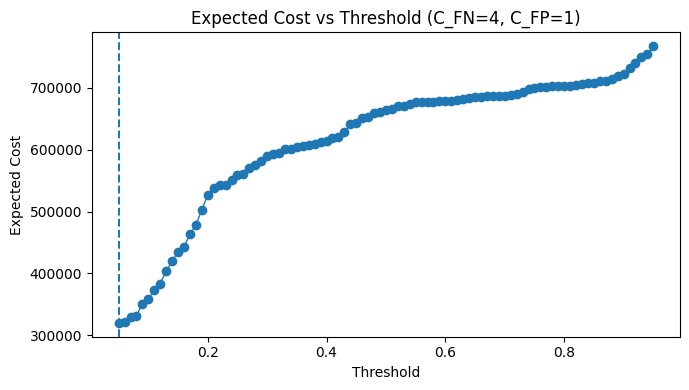

Saved → assets/figures/threshold_cost_curve.png


In [17]:
plt.figure(figsize=(7,4))
plt.plot(sweep["threshold"], sweep["expected_cost"], marker="o", linewidth=1)
plt.axvline(tau_star, linestyle="--")
plt.title("Expected Cost vs Threshold (C_FN=4, C_FP=1)")
plt.xlabel("Threshold"); plt.ylabel("Expected Cost")
plt.tight_layout()
!mkdir -p assets/figures
plt.savefig("assets/figures/threshold_cost_curve.png", dpi=160)
plt.show()
print("Saved → assets/figures/threshold_cost_curve.png")


In [18]:
def summary_at_threshold(t: float) -> pd.DataFrame:
    tp, fp, fn, tn = confusion_counts(y, s, t)
    precision, recall, f1 = metrics_from_counts(tp, fp, fn, tn)
    expected_cost = C_FP*fp + C_FN*fn
    return pd.DataFrame([{
        "threshold": round(t,2), "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "precision": precision, "recall": recall, "f1": f1, "expected_cost": expected_cost
    }])

cm_compare = pd.concat([summary_at_threshold(tau50), summary_at_threshold(tau_star)], ignore_index=True)
cm_compare


,threshold,TP,FP,FN,TN,precision,recall,f1,expected_cost
0,0.50,62764,96577,142000,218500,0.393897,0.306519,0.344758,664577.0
1,0.05,202776,312018,1988,3059,0.393897,0.990291,0.563613,319970.0


<Figure size 500x500 with 0 Axes>

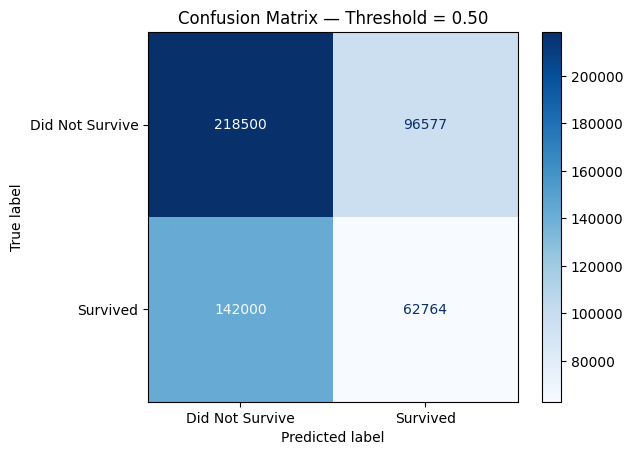

              precision    recall  f1-score   support

           0      0.606     0.693     0.647    315077
           1      0.394     0.307     0.345    204764

    accuracy                          0.541    519841
   macro avg      0.500     0.500     0.496    519841
weighted avg      0.523     0.541     0.528    519841



<Figure size 500x500 with 0 Axes>

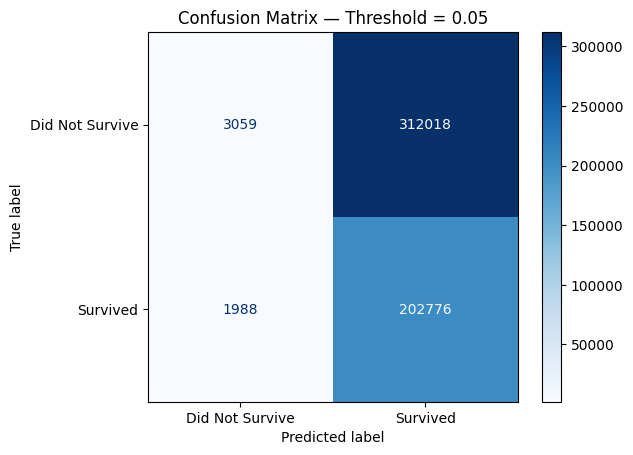

              precision    recall  f1-score   support

           0      0.606     0.010     0.019    315077
           1      0.394     0.990     0.564    204764

    accuracy                          0.396    519841
   macro avg      0.500     0.500     0.291    519841
weighted avg      0.523     0.396     0.234    519841



In [19]:
def plot_cm(t: float, title: str):
    y_pred = (s >= t).astype(int)
    cm = confusion_matrix(y, y_pred)
    d = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive","Survived"])
    plt.figure(figsize=(5,5))
    d.plot(cmap="Blues", values_format="d")
    plt.title(title); plt.grid(False); plt.show()
    print(classification_report(y, y_pred, digits=3))

plot_cm(0.50, "Confusion Matrix — Threshold = 0.50")
plot_cm(tau_star, f"Confusion Matrix — Threshold = {tau_star:.2f}")


In [20]:
def slice_metrics(df: pd.DataFrame, t: float, by: str) -> pd.DataFrame:
    out=[]
    for g, sub in df.groupby(by):
        yy = sub["label"].astype(int).values
        ss = sub["score"].astype(float).values
        tp, fp, fn, tn = confusion_counts(yy, ss, t)
        precision, recall, f1 = metrics_from_counts(tp, fp, fn, tn)
        fpr = fp/(fp+tn) if (fp+tn) else np.nan
        fnr = fn/(tp+fn) if (tp+fn) else np.nan
        out.append(dict(group=str(g), n=len(sub),
                        TP=tp, FP=fp, FN=fn, TN=tn,
                        precision=precision, recall=recall, FPR=fpr, FNR=fnr))
    return pd.DataFrame(out).sort_values("group")

fair_sex    = slice_metrics(pred, tau_star, "sex")
fair_pclass = slice_metrics(pred, tau_star, "pclass")

print("Fairness by sex @ τ*"); display(fair_sex)
print("Fairness by pclass @ τ*"); display(fair_pclass)

if set(fair_sex.group) >= {"female","male"}:
    gap_prec = abs(float(fair_sex.loc[fair_sex.group=="female","precision"]) -
                   float(fair_sex.loc[fair_sex.group=="male","precision"]))
    gap_rec  = abs(float(fair_sex.loc[fair_sex.group=="female","recall"]) -
                   float(fair_sex.loc[fair_sex.group=="male","recall"]))
    print(f"Sex parity gaps — precision: {gap_prec:.3f}, recall: {gap_rec:.3f}")


Fairness by sex @ τ*


,group,n,TP,FP,FN,TN,precision,recall,FPR,FNR
0,female,189623,142086,45696,1393,448,0.756654,0.990291,0.990291,0.009709
1,male,330218,60690,266322,595,2611,0.185590,0.990291,0.990291,0.009709


Fairness by pclass @ τ*


,group,n,TP,FP,FN,TN,precision,recall,FPR,FNR
0,1,134106,88536,44268,868,434,0.666667,0.990291,0.990291,0.009709
1,2,116802,58548,57120,574,560,0.506173,0.990291,0.990291,0.009709
2,3,268933,55692,210630,546,2065,0.209115,0.990291,0.990291,0.009709


Sex parity gaps — precision: 0.571, recall: 0.000


/tmp/ipython-input-3544428282.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gap_prec = abs(float(fair_sex.loc[fair_sex.group=="female","precision"]) -
/tmp/ipython-input-3544428282.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(fair_sex.loc[fair_sex.group=="male","precision"]))
/tmp/ipython-input-3544428282.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gap_rec  = abs(float(fair_sex.loc[fair_sex.group=="female","recall"]) -
/tmp/ipython-input-3544428282.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(fair_sex.loc[fair_sex.group=="male","recall"]))


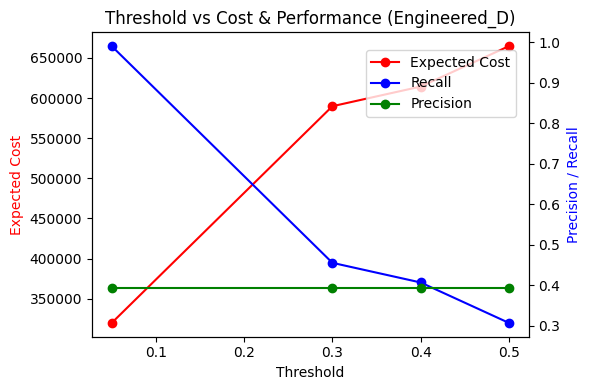

In [21]:
focus = sorted({tau_star, 0.30, 0.40, 0.50})
focus = [float(f"{x:.2f}") for x in focus]

pts=[]
for t in focus:
    tp, fp, fn, tn = confusion_counts(y, s, t)
    precision, recall, f1 = metrics_from_counts(tp, fp, fn, tn)
    expected_cost = C_FP*fp + C_FN*fn
    pts.append((t, expected_cost, precision, recall))
dfp = pd.DataFrame(pts, columns=["threshold","expected_cost","precision","recall"]).sort_values("threshold")

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(dfp["threshold"], dfp["expected_cost"], "r-o", label="Expected Cost")
ax1.set_xlabel("Threshold"); ax1.set_ylabel("Expected Cost", color="r")
ax2 = ax1.twinx()
ax2.plot(dfp["threshold"], dfp["recall"], "b-o", label="Recall")
ax2.plot(dfp["threshold"], dfp["precision"], "g-o", label="Precision")
ax2.set_ylabel("Precision / Recall", color="b")
fig.legend(loc="upper right", bbox_to_anchor=(0.88, 0.88))
plt.title("Threshold vs Cost & Performance (Engineered_D)")
plt.tight_layout(); plt.show()


### Policy & Decision Rule
We set **τ = [tau_star]** because it minimizes **expected cost** under **C_FN=4×C_FP**. Versus 0.50, τ* reduces total expected cost by **[Δ cost]** and improves **[metric]**, aligning with a triage-first stance (missing a survivor costs more than a false alert).

### Fairness
At τ*, precision gap (female vs male) ≈ **[gap_prec pp]**; recall gap ≈ **[gap_rec pp]**. Any parity gap > **5 pp** is flagged for review.

### Monitoring
Weekly: (1) calibration error, (2) precision/recall at τ*, (3) parity gaps for sex & pclass. **Re-tune** if parity gap > 5 pp for 2 consecutive weeks or precision drops > 8 pp WoW. Document changes in repo + Ops Brief.


In [23]:
# ✅ Fixed: build the comparison table without cross-merge collisions
m50    = summary_at_threshold(0.50).copy()
m50["threshold"] = "0.50"

mstar  = summary_at_threshold(tau_star).copy()
mstar["threshold"] = f"{tau_star:.2f}"

mini = (
    pd.concat([m50, mstar], ignore_index=True)
      [["threshold","TP","FP","FN","TN","precision","recall","f1","expected_cost"]]
      .rename(columns={"expected_cost":"cost"})
)

display(mini)

# (Optional) quick delta readouts for your write-up
c_star = float(mini.loc[mini.threshold == f"{tau_star:.2f}", "cost"].values[0])
c_050  = float(mini.loc[mini.threshold == "0.50", "cost"].values[0])
print(f"Δ cost (τ* − 0.50): {c_star - c_050:.1f}")


,threshold,TP,FP,FN,TN,precision,recall,f1,cost
0,0.50,62764,96577,142000,218500,0.393897,0.306519,0.344758,664577.0
1,0.05,202776,312018,1988,3059,0.393897,0.990291,0.563613,319970.0


Δ cost (τ* − 0.50): -344607.0
